# 👋 Introduction

The medication status of PD patients is important as medication importantly affects clinical measures such as the Hoehn & Yahr score used in many studies. In PPMI, medication is available through the following main variables:
* PDSTATE (ON/OFF): the current functional state of the patient
* PDTRTMNT (0/1): 1 if the participant is on PD medication or receives deep brain stimulation, 0 otherwise
* PDMEDTM: time of most recent PD medication dose
* PDMEDDT: date of most recent PD medication dose

As mentioned in the "Methods for Defining PD Med Use" in PPMI study data, OFF state requires that the last dose of levodopa or dopamine agonist was taken 6 hours or more before MDS-UPDRS Part III assessment.

The goal of this notebook is (1) to identify and correct inconsistencies among these variables, (2) to impute missing data for PDSTATE and PDTRTMNT, and (3) to check the sanity of the corrected dataset.

In [1]:
from IPython.display import HTML

HTML(
    """<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the Python code."></form>"""
)

In [2]:
import datetime
import warnings

import pytz


warnings.filterwarnings('ignore')

now = datetime.datetime.now(pytz.utc).strftime('%Y-%m-%d %H:%M:%S %Z %z')
print(f"This notebook was run on {now}")

This notebook was run on 2022-07-06 18:46:25 UTC +0000


# 🔽 Data download

The above-mentioned variables are available in PPMI file `MDS_UPDRS_Part_III.csv`. To download this file, we will use package `ppmi-downloader` available on PyPi. The package will ask you for your PPMI login and password.

In [3]:
import os
import os.path as op

import pandas as pd
import ppmi_downloader


data_dir = "data"

if not op.exists(data_dir):
    os.makedirs(data_dir)
required_files = ["MDS_UPDRS_Part_III.csv"]
missing_files = [x for x in required_files if not op.exists(os.path.join(data_dir, x))]

if len(missing_files) > 0:
    ppmi = ppmi_downloader.PPMIDownloader()
    ppmi.download_metadata(
        missing_files, destination_dir=data_dir, headless=False, timeout=600
    )

df = pd.read_csv(op.join(data_dir, "MDS_UPDRS_Part_III.csv"))

print("File downloaded")

File downloaded


# ⁉️ Inconsistencies

## Records with no value

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem:</b> some records have missing data for all UPDRS-III variables.
</div>

Number of records with NaNs for all UPDRS-III variables:

In [4]:
updrs3_vars = [
    "PDMEDDT",
    "PDMEDTM",
    "PDSTATE",
    "EXAMTM",
    "DBS_STATUS",
    "NP3SPCH",
    "NP3FACXP",
    "NP3RIGN",
    "NP3RIGRU",
    "NP3RIGLU",
    "NP3RIGRL",
    "NP3RIGLL",
    "NP3FTAPR",
    "NP3FTAPL",
    "NP3HMOVR",
    "NP3HMOVL",
    "NP3PRSPR",
    "NP3PRSPL",
    "NP3TTAPR",
    "NP3TTAPL",
    "NP3LGAGR",
    "NP3LGAGL",
    "NP3RISNG",
    "NP3GAIT",
    "NP3FRZGT",
    "NP3PSTBL",
    "NP3POSTR",
    "NP3BRADY",
    "NP3PTRMR",
    "NP3PTRML",
    "NP3KTRMR",
    "NP3KTRML",
    "NP3RTARU",
    "NP3RTALU",
    "NP3RTARL",
    "NP3RTALL",
    "NP3RTALJ",
    "NP3RTCON",
    "NP3TOT",
    "DYSKPRES",
    "DYSKIRAT",
    "NHY",
    "DBSONTM",
    "DBSOFFTM",
    "HRPOSTMED",
    "HRDBSOFF",
    "HRDBSON",
]

In [5]:
len(df[df[updrs3_vars].isnull().all(axis=1)])

128

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction</b>: remove these records.
</div>

⚙️ Implementation



In [6]:
df = df[df[updrs3_vars].notna().any(axis=1)]

Updated number of records with NaNs for all UPDRS-III variables:

In [7]:
len(df[df[updrs3_vars].isnull().all(axis=1)])

0

## PDTRTMNT=0 and PDSTATE=ON

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem:</b> a few records have PDSTATE=ON and PDTRTMNT=0, which is inconsistent:
</div>

In [8]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0           18
        1.0         3088
        NaN            6
ON      0.0           10
        1.0         5218
        NaN            1
NaN     0.0         7492
        1.0          135
        NaN         2322

The lines below show the difference between EXAMTM and PDMEDTM. All the records have a PDMEDTM that is earlier to EXAMTM by at most 5 hours:

In [9]:
errors = df[(df["PDSTATE"] == "ON") & (df["PDTRTMNT"] == 0)]
# print the time difference between EXAMTM and PDMEDTM
(pd.to_datetime(errors["EXAMTM"]) - pd.to_datetime(errors["PDMEDTM"]))

6566    0 days 01:00:00
7401    0 days 01:00:00
8073    0 days 01:25:00
10507   0 days 04:30:00
11527   0 days 00:40:00
11556   0 days 00:00:00
11557   0 days 01:54:00
15716   0 days 03:50:00
17272   0 days 00:15:00
17745   0 days 05:00:00
dtype: timedelta64[ns]

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction</b>: set PDTRTMNT to 1 for these records. It doesn't seem realistic that a plausible PDMEDTM and PDSTATE=ON have been entered by mistake while the patient was not under medication.
</div>

⚙️ Implementation



In [10]:
df.loc[(df["PDSTATE"] == "ON") & (df["PDTRTMNT"] == 0), "PDTRTMNT"] = 1

Let's verify that the inconsistency is now resolved:

In [11]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0           18
        1.0         3088
        NaN            6
ON      1.0         5228
        NaN            1
NaN     0.0         7492
        1.0          135
        NaN         2322

## PDTRTMNT=0 and PDMEDTM not empty

<div class="alert alert-block alert-danger">
 	&#10060; <b>Problem:</b> some records have a non-empty PDMEDTIME and have PDTRTMNT=0, which is inconsistent.
    </div>

Number of records with a non-empty PDMEDTIME and PDTRTMNT=0:

In [12]:
errors = df[(df["PDMEDTM"].notnull()) & (df["PDTRTMNT"] == 0)]
len(errors)

474

PDMEDTIME values for these records look plausible:

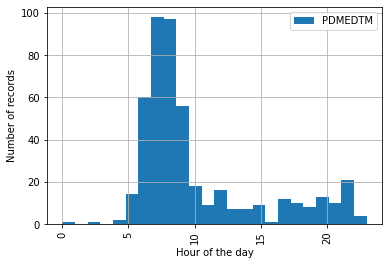

In [13]:
from matplotlib import pyplot as plt

pd.to_datetime(errors["PDMEDTM"]).dt.hour.hist(bins=24, xrot=90, legend=True)
plt.xlabel("Hour of the day")
plt.ylabel("Number of records")
plt.show()

<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction:</b> set PDTRTMNT=1. It is unlikely that a plausible medication time was entered by mistake.
</div>

⚙️ Implementation

In [14]:
df.loc[(df["PDTRTMNT"] == 0) & (df["PDMEDTM"].notnull()), "PDTRTMNT"] = 1

Let's verify that the inconsistency is now fixed by counting the number of records with a non-empty PDMEDTIME and PDTRTMNT=0:

In [15]:
errors = df[(df["PDMEDTM"].notnull()) & (df["PDTRTMNT"] == 0)]
len(errors)

0

## EVENT_ID = SC and PDTRTMNT = 1

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem</b>: Some patients were on medication at screening time while PPMI patients were supposed to be unmedicated at screening time.
    </div>

Number of patients on medication at screening time:

In [16]:
len(df[(df["EVENT_ID"] == "SC") & (df["PDTRTMNT"] == 1)])

9

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction:</b> keep the records. Maybe the patients started medication between recruitment and screening time.
</div>

## PDSTATE=ON and EXAMTM<PDMEDTM

<div class="alert alert-block alert-danger">
     	&#10060; <b>Problem</b>: Some records have PDSTATE=ON but PDMEDTM is after EXAMTM. 
    </div>

Number of records where PDSTATE=ON and EXAMTM<PDMEDTM:

In [17]:
# ON records
on = df[df["PDSTATE"] == "ON"]


def to_secs(x):
    """
    Convert time from hh:mm to seconds since midnight

    x: time in hh:ss format
    return: number of seconds elapsed since midnight
    """
    if str(x) == "nan":
        import numpy as np

        return np.NaN
    try:
        hour, mn, sec = x.split(":")
    except Exception as e:
        print(f'Cannot process "{x}"')
        raise (e)
    return int(hour) * 3600 + int(mn) * 60 + int(sec)


on["delta"] = on["EXAMTM"].apply(to_secs) - on["PDMEDTM"].apply(to_secs)
len(on[on["delta"] < 0])

38

<div class="alert alert-block alert-success">
     	&#10003; <b>Proposed correction:</b> discard the records. 
</div>

Note: for some of these records, medication date was likely on the day before the exam, although this cannot be verified since dates only contain a year and a month but no day. Even in such cases, duration between medication time and exam time was more than 6 hours which is inconsistent with the rule used for the other records.

⚙️ Implementation

In [18]:
before = len(df)
df = df[
    ~(
        (df["PDSTATE"] == "ON")
        & df["EXAMTM"].notnull()
        & df["PDMEDTM"].notnull()
        & (df["EXAMTM"] < df["PDMEDTM"])
    )
]
print(f"Removed {before-len(df)} records where PDSTATE=ON and EXAMTM<PDMEDTM")

Removed 38 records where PDSTATE=ON and EXAMTM<PDMEDTM


## Visits with 3 exams

<div class="alert alert-block alert-danger">
    	&#10060; <b>Problem</b>: some visits have 3 exams while a maximum of two exams per visit are expected, one in OFF state and one in ON state.
</div>

Number of records that belong to a visit with more than 3 exams:

In [19]:
pb = df.groupby(["PATNO", "EVENT_ID"]).filter(lambda x: len(x) > 2)
len(pb)

15

Each exams triple has an exam with missing EXAMTM and missing PDSTATE:

In [20]:
pb = df.groupby(["PATNO", "EVENT_ID"]).filter(lambda x: len(x) > 2)
pb_trunc = pb[["EVENT_ID", "PDSTATE", "EXAMTM"]]
from IPython.display import HTML

HTML(pb_trunc.to_html(index=False))

EVENT_ID,PDSTATE,EXAMTM
V16,NaN,NaN
V16,OFF,08:35:00
V16,ON,09:36:00
V16,ON,12:45:00
V16,NaN,NaN
V16,OFF,10:48:00
V14,OFF,10:20:00
V14,ON,12:00:00
V14,NaN,NaN
V13,OFF,09:18:00


<div class="alert alert-block alert-success">
  	&#10003;   <b>Proposed correction:</b> remove exam with EXAMTM=NaN and PDSTATE=NaN when visit has 3 exams.
</div>

⚙️ Implementation

In [21]:
a = df.groupby(["PATNO", "EVENT_ID"]).filter(lambda x: len(x) > 2)
index = (a[(a["PDSTATE"].isnull()) & (a["EXAMTM"].isnull())]).index

before_len = len(df)
df = df[~df.index.isin(index)]
print(f"Number of removed records: {before_len-len(df)}")

Number of removed records: 5


Let's verify that the inconsistency is solved by counting the number of records that belong to a visit with more than 3 exams:

In [22]:
pb = df.groupby(["PATNO", "EVENT_ID"]).filter(lambda x: len(x) > 2)
len(pb)

0

# 🕵️ Imputation of missing PDSTATE or PDTRTMNT

<div class="alert alert-block alert-danger">
    	&#10060; <b>Problem:</b> variables PDSTATE and PDTRTMNT have missing data, which makes it difficult to identify when/if a patient was under medication.
</div>

The following table summarizes the number of records for which PDSTATE or PDTRTMNT is missing:

In [23]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0           14
        1.0         3092
        NaN            6
ON      1.0         5190
        NaN            1
NaN     0.0         7017
        1.0          605
        NaN         2322

The following cases will be treated separately in the following sections:

|               |PDSTATE | PDTRTMNT | Number of records |
|---------------|--------|----------|-------------------|
| **Case 1**  | OFF    | NaN      | 6                 |
| **Case 2** | NaN    | 0        | 6947          |
| **Case 3**|  NaN   | 1        | 633               |
| **Case 4** | NaN    | NaN      | 2322             |
| **Case 5**  | ON     | NaN      | 1                 |

## Case 1: PDSTATE=OFF and PDTRTMNT=NaN

No record in case 1 has a medication date (PDMEDDT), a medication time (PDMEDTM), or
a DBS status (DBS_STATUS):

In [24]:
case_1 = df[(df["PDSTATE"] == "OFF") & (df["PDTRTMNT"].isnull())]
case_1.groupby(
    [
        "PDMEDDT",
        "PDMEDTM",
        "DBS_STATUS",
        "HRPOSTMED",
        "DBSONTM",
        "DBSOFFTM",
        "HRDBSOFF",
        "HRDBSON",
    ],
    dropna=False,
)[["REC_ID"]].count()

,,,,,,,,REC_ID
PDMEDDT,PDMEDTM,DBS_STATUS,HRPOSTMED,DBSONTM,DBSOFFTM,HRDBSOFF,HRDBSON,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


<div class="alert alert-block alert-success">
 	&#10003;    <b>Proposed correction</b>: set PDTRTMNT=0. It is unlikely that these records correspond to medicated patients when none of the variables related to medication have a value.
</div>

⚙️ Implementation

In [25]:
df.loc[(df["PDSTATE"] == "OFF") & (df["PDTRTMNT"].isnull()), "PDTRTMNT"] = 0

Let's verify that case 1 is now resolved:

In [26]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0           20
        1.0         3092
ON      1.0         5190
        NaN            1
NaN     0.0         7017
        1.0          605
        NaN         2322

## Case 2: PDSTATE=NaN and PDTRTMNT=0

<div class="alert alert-block alert-success">
   	&#10003;   <b>Proposed correction</b>: set PDSTATE=OFF. The patient is not medicated and for this reason PDSTATE is likely to not have been entered.
</div>

⚙️ Implementation

In [27]:
df.loc[(df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 0), "PDSTATE"] = "OFF"

Let's verify that case 2 is now resolved:

In [28]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3092
ON      1.0         5190
        NaN            1
NaN     1.0          605
        NaN         2322

## Case 3: PDSTATE=NaN and PDTRTMNT=1

<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction</b>: 
    <ul>
        <li>(a) <b>IF</b> record belongs to a visit with two exams:</li>
            <ul>
                <li> Set PDSTATE=OFF for record with earliest EXAMTM</li>
                <li> Set PDSTATE=ON for record with latest EXAMTM</li>
            </ul>
        <li>(b) <b>ELSE</b>: determine PDSTATE as a function of PDMEDTM and EXAMTM:</li>
            <ul>
                <li>(i) <b>IF</b> PDMEDTM or EXAMTM are missing <b>THEN</b> discard record.</li>
                <li> (ii) <b>IF</b> PDMEDTM is earlier than EXAMTM:</li>
                    <ul>
                        <li><b>IF</b> EXAMTM-PDMEDTM < 6 hours (PPMI cut-off)<b>THEN</b>:
                <ul><li><b>IF</b> EXAMTM-PDMEDTM >= 30 min <b>THEN</b> set PDSTATE=ON.</li>
                    <li><b>ELSE</b>: discard record.</ul>
        <li><b>ELSE:</b> set PDSTATE=OFF</li>
                    </ul>
                <li> (iii) <b>IF</b> PDMEDTM is later than EXAMTM <b>THEN</b>:
                    <UL>
                        <li>(a) <b>IF</b> PDMEDTM is later than 4pm <b>THEN</b> assume record belongs to the previous day, set PDSTATE=OFF.</li>
                        <li>(b) <b>ELSE</b>                     
                    discard record.
                            </ul></li>
    </ul>
    
    
  
</div>

⚙️ Implementation

Let's implement each sub-case separately.

### Case 3.a: visits with two exams

Let's count the number of records in case 3.a:

In [29]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)
a = df[case_3].groupby(["PATNO", "EVENT_ID"]).filter(lambda x: len(x) == 2)
print(f"Found {len(a)} records in Case 3.a")

Found 0 records in Case 3.a


### Case 3.b.i: visits with one exam, missing EXAMTM or PDMEDTM

Number of records in case 3.b with missing EXAMTM or missing PDMEDTM:

In [30]:
len(df[case_3 & ((df["EXAMTM"].isnull()) | (df["PDMEDTM"].isnull()))])

1

In [31]:
before_len = len(df)
df.drop(
    df[case_3 & ((df["EXAMTM"].isnull()) | (df["PDMEDTM"].isnull()))].index,
    inplace=True,
)
print(f"Removed {before_len-len(df)} record(s) with missing EXAMTM or PDMEDTM")

Removed 1 record(s) with missing EXAMTM or PDMEDTM


Updated records distribution in case 3:

In [32]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3092
ON      1.0         5190
        NaN            1
NaN     1.0          604
        NaN         2322

In [33]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)

### Case 3.b.ii: visits with one exam, PDMEDTM earlier than EXAMTM

Number of records in case 3.b where PDMEDTM is earlier or equal to EXAMTM:

In [34]:
len(df[case_3 & (df["PDMEDTM"] <= df["EXAMTM"])])

396

In [35]:
def to_secs(x):
    if str(x) == "nan":
        import numpy as np

        return np.NaN
    try:
        hour, mn, sec = x.split(":")
    except Exception as e:
        print(f'Cannot process "{x}"')
        raise (e)
    return int(hour) * 3600 + int(mn) * 60 + int(sec)

Number of records in case 3.b where PDMEDTM is earlier or equal to EXAMTM and $30\,min \le \text{EXAMTM}-\text{PDMEDTM} < 6\,hours$:

In [36]:
len(
    df[
        case_3
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 1800)
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) < 6 * 3600)
    ]
)

331

Let's set PDSTATE=ON for these records.

In [37]:
df.loc[
    case_3
    & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 1800)
    & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) < 6 * 3600),
    "PDSTATE",
] = "ON"

Updated records distribution:

In [38]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3092
ON      1.0         5521
        NaN            1
NaN     1.0          273
        NaN         2322

In [39]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)

Number of records in case 3.b where PDMEDTM is earlier or equal to EXAMTM and $\text{EXAMTM-PDMEDTM} < 30\,min$:

In [40]:
len(
    df[
        case_3
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) < 1800)
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 0)
    ]
)

30

Let's discard these records:

In [41]:
df.drop(
    df[
        case_3
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) < 1800)
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 0)
    ].index,
    inplace=True,
)

Updated records distribution:

In [42]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3092
ON      1.0         5521
        NaN            1
NaN     1.0          243
        NaN         2322

In [43]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)

Number of records in case 3.b where PDMEDTM is earlier or equal to EXAMTM and $\text{EXAMTM-PDMEDTM} \ge 6\,hours$:

In [44]:
len(
    df[
        case_3
        & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 6 * 3600)
    ]
)

35

Let's set PDSTATE=OFF for these records.

In [45]:
df.loc[
    case_3 & (df["EXAMTM"].apply(to_secs) - df["PDMEDTM"].apply(to_secs) >= 6 * 3600),
    "PDSTATE",
] = "OFF"

Updated records distribution:

In [46]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3127
ON      1.0         5521
        NaN            1
NaN     1.0          208
        NaN         2322

### Case 3.b.iii: PDMEDTM is later than EXAMTM

Number of records in case 3.b where PDMEDTM is later than EXAMTM:

In [47]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)
len(df[case_3 & (df["PDMEDTM"] > df["EXAMTM"])])

208

#### Case 3.b.iii.a: PDMEDTM is after 4pm

Some of records have a PDMEDTIME which likely belongs to the previous day but there is no way to confirm it because dates only include a month, a year, but no day. Looking at the distribution of exam times in such cases, we noticed that no exam took place after 4pm, which motivates the use of 4pm as cut-off time.

Distribution of EXAM times when $\text{PDMEDTM} > \text{EXAMTM}$:

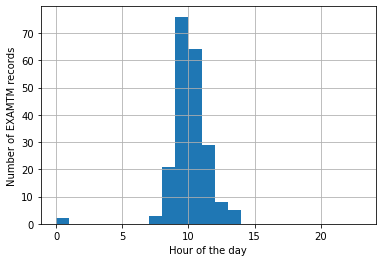

In [48]:
import numpy as np

pd.to_datetime(
    df[case_3 & (df["PDMEDTM"].apply(to_secs) > df["EXAMTM"].apply(to_secs))]["EXAMTM"]
).dt.hour.hist(bins=np.arange(24))
plt.xlabel("Hour of the day")
plt.ylabel("Number of EXAMTM records");

Number of records in case 3 where PDMEDTM is after EXAMTM and PDMEDTM is after 4pm:

In [49]:
len(
    df[
        case_3
        & (df["PDMEDTM"].apply(to_secs) > df["EXAMTM"].apply(to_secs))
        & (df["PDMEDTM"] > "16:00:00")
    ]
)

120

Let's set PDSTATE=OFF for these records:

In [50]:
df.loc[
    case_3
    & (df["PDMEDTM"].apply(to_secs) > df["EXAMTM"].apply(to_secs))
    & (df["PDMEDTM"] > "16:00:00"),
    "PDSTATE",
] = "OFF"

Updated records distribution:

In [51]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3247
ON      1.0         5521
        NaN            1
NaN     1.0           88
        NaN         2322

In [52]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)

#### Case 3.b.iii.a: PDMEDTM is before 4pm

Number of records in case 3 where PDMEDTM is later than EXAMTM and PDMEDTM is before 4pm:

In [53]:
len(df[case_3 & (df["EXAMTM"].apply(to_secs) < df["PDMEDTM"].apply(to_secs))])

88

Let's remove these records. 

In [54]:
df.drop(
    df[case_3 & (df["EXAMTM"].apply(to_secs) < df["PDMEDTM"].apply(to_secs))].index,
    inplace=True,
)

In [55]:
case_3 = (df["PDSTATE"].isnull()) & (df["PDTRTMNT"] == 1)

Let's verify that case 3 (PDSTATE=NaN, PDTRTMNT=1) is now resolved:

In [56]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         7037
        1.0         3247
ON      1.0         5521
        NaN            1
NaN     NaN         2322

## Case 4: PDSTATE=NaN and PDTRTMNT=NaN

Similar to case 1, no record in case 4 has a medication date (PDMEDDT), a medication time (PDMEDTM), or
a DBS status (DBS_STATUS):

In [57]:
case_4 = df[(df["PDSTATE"].isnull()) & (df["PDTRTMNT"].isnull())]
case_4.groupby(
    [
        "PDMEDDT",
        "PDMEDTM",
        "DBS_STATUS",
        "HRPOSTMED",
        "DBSONTM",
        "DBSOFFTM",
        "HRDBSOFF",
        "HRDBSON",
    ],
    dropna=False,
).count()

,,,,,,,,REC_ID,PATNO,EVENT_ID,PAG_NAME,INFODT,PDSTATE,EXAMTM,NP3SPCH,NP3FACXP,NP3RIGN,...,NP3RTALL,NP3RTALJ,NP3RTCON,NP3TOT,DYSKPRES,DYSKIRAT,NHY,PDTRTMNT,ORIG_ENTRY,LAST_UPDATE
PDMEDDT,PDMEDTM,DBS_STATUS,HRPOSTMED,DBSONTM,DBSOFFTM,HRDBSOFF,HRDBSON,,,,,,,,,,,,,,,,,,,,,
NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2322,2322,2322,2322,2322,0,1135,2322,2322,2321,...,2321,2321,2320,2314,2320,40,2320,0,2322,2322


<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed solution</b>: set PDSTATE=OFF and PDTRTMNT=0. It is very unlikely that the patient was medicated and none of the 8 medication-related variables were set.
</div>

⚙️ Implementation

In [58]:
df_1 = df.copy()
df_1.loc[(df["PDSTATE"].isnull()) & (df["PDTRTMNT"].isnull()), "PDSTATE"] = "OFF"
df_1.loc[(df["PDSTATE"].isnull()) & (df["PDTRTMNT"].isnull()), "PDTRTMNT"] = 0
df = df_1

Let's verify that case 4 is now resolved:

In [59]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         9359
        1.0         3247
ON      1.0         5521
        NaN            1

## Case 5: PDSTATE=ON and PDTRTMNT=NaN


<div class="alert alert-block alert-success">
    	&#10003; <b>Proposed correction</b>: set PDTRTMNT=1. The patient is medicated since PDSTATE=ON.
</div>

⚙️ Implementation

In [60]:
df.loc[(df["PDSTATE"] == "ON") & (df["PDTRTMNT"].isnull()), "PDTRTMNT"] = 1

Let's verify that case 5 is now resolved:

In [61]:
df.groupby(["PDSTATE", "PDTRTMNT"], dropna=False)[["REC_ID"]].count()

REC_ID
PDSTATE PDTRTMNT        
OFF     0.0         9359
        1.0         3247
ON      1.0         5522

There's no remaining missing PDSTATE or PDTRTMNT value in the data!

Let's save the cleaned file:

In [62]:
filename = "MDS_UPDRS_Part_III_clean.csv"
df.to_csv(op.join(data_dir, filename), index=False)
print(f"Cleaned file saved in {filename}")

Cleaned file saved in MDS_UPDRS_Part_III_clean.csv


# ⚕️ Sanity checks

The following sanity checks are applied to the cleaned UPDRS-III data.

**IF** visit has two exam **THEN** one is ON and the other one is OFF:

In [63]:
a = df.groupby(['PATNO', 'EVENT_ID']).filter(lambda x: len(x)==2)
a.groupby(['PATNO', 'EVENT_ID']).filter(lambda x: x.iloc[[0]]['PDSTATE'].to_string() ==
                                                  x.iloc[[1]]['PDSTATE'].to_string()).empty

True

**IF** PDSTATE=ON **THEN** EXAMTM>PDMEDTM

In [64]:
df[
    (df["PDSTATE"] == "ON")
    & (df["EXAMTM"].apply(to_secs) < df["PDMEDTM"].apply(to_secs))
].empty

True

**IF** PDTRTMNT=0 **THEN** there is a single visit and PDSTATE=off

In [65]:
assert (
    df[df["PDTRTMNT"] == 0]
    .groupby(["PATNO", "EVENT_ID"])
    .filter(lambda x: len(x) > 1)
    .empty
), "False!"
assert (
    df[df["PDTRTMNT"] == 0]
    .groupby(["PATNO", "EVENT_ID"])
    .filter(lambda x: x["PDSTATE"] != "OFF")
    .empty
), "False!"
print("True")

True


A patient cannot become unmedicated after being medicated:

In [66]:
def wrong_pairs(x):
    rows = [row for index, row in x.iterrows()]
    for a in rows:
        for b in rows:
            if a['EVENT_ID'] == b['EVENT_ID']:
                continue
            # If dates are equal, we cannot say anything
            if pd.to_datetime(a['INFODT']) == pd.to_datetime(b['INFODT']):
                return False                   
            # If a is later than b, a['PDTRTMNT'] has to be larger or equal to b['PDTRTMNT']
            if pd.to_datetime(a['INFODT']) > pd.to_datetime(b['INFODT']):
                if int(a['PDTRTMNT']) < int(b['PDTRTMNT']):
                    return True
                return False
            # a is earlier than b: a['PDTRTMNT'] has to be lower or equal to b['PDTRTMNT']
            if int(a['PDTRTMNT']) > int(b['PDTRTMNT']):
                return True
            return False

df.groupby(['PATNO']).filter(lambda x: x['PDTRTMNT'].nunique() > 1).groupby('PATNO').filter(wrong_pairs).empty

True

In [67]:
# off = (df['PDSTATE']=='OFF') & (df['PDMEDTM']<='16:00:00')
# df['EXAMsecs'] = df[off]['EXAMTM'].apply(to_secs)
# df['PDMEDTMsecs'] = df[off]['PDMEDTM'].apply(to_secs)

# df[off & (df['EXAMsecs']-df['PDMEDTMsecs']>=0) & (df['EXAMsecs']-df['PDMEDTMsecs']<6*3600)]

In [68]:
# off = (df['PDSTATE']=='OFF') & (df['PDMEDTM']<='16:00:00')
# df['EXAMsecs'] = df[off]['EXAMTM'].apply(to_secs)
# df['PDMEDTMsecs'] = df[off]['PDMEDTM'].apply(to_secs)

# df[off & (df['EXAMsecs']-df['PDMEDTMsecs']>=0) & (df['EXAMsecs']-df['PDMEDTMsecs']<6*3600)]